# Split GLIMS into GTNG Glacier Regions
Author: Ann Windnagel

Date: 3/3/2019

This notebook splits the one large GLIMS shapefile into 19 different shapefiles based on the 19 GTNG Glacier Regions. This will allow for the comparison of GLIMS to the RGI data which came already separated into the 19 regions.

In [1]:
import os
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import sys

import geopandas as gpd
from shapely.geometry import mapping, box
from shapely.geometry import Point, Polygon

import earthpy as et
import earthpy.spatial as es
import earthpy.clip as cl

# set working dir
os.chdir(os.path.join(et.io.HOME, "git/wgms-glacier-project"))

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

In [2]:
# Open GLIMS polygons using geopandas
glims_file_path = "data/glims/raw/glims_download_20190304/glims_polygons.shp"
glims_polygons = gpd.read_file(glims_file_path)
glims_polygons.head()

,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,...,rc_id,geog_area,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,geometry
0,debris_cov,121031.0,G006338E44942N,2013-03-25T00:00:00,0.0041,0.010639,0.0,61.1478,0.0,3040.0,...,33.0,French Alps,Laboratoire de Glaciologie et Géophysique de l...,30,30,30,30,"Rabatel, Antoine","Rabatel, Antoine","POLYGON Z ((6.339466 44.942715 0, 6.339479 44...."
1,debris_cov,121554.0,G006337E44931N,2013-03-20T00:00:00,1.9080,1.907390,0.0,3558.5700,0.0,2434.0,...,33.0,French Alps,Laboratoire de Glaciologie et Géophysique de l...,30,30,30,30,"Rabatel, Antoine","Rabatel, Antoine","POLYGON Z ((6.341819 44.932777 0, 6.341794 44...."
2,debris_cov,121554.0,G006337E44931N,2013-03-20T00:00:00,1.9080,1.907390,0.0,3558.5700,0.0,2434.0,...,33.0,French Alps,Laboratoire de Glaciologie et Géophysique de l...,30,30,30,30,"Rabatel, Antoine","Rabatel, Antoine","POLYGON Z ((6.343297 44.93374 0, 6.34329 44.93..."
3,debris_cov,121367.0,G006992E45913N,2013-03-25T00:00:00,7.6856,7.687140,0.0,5010.4600,0.0,2276.0,...,33.0,French Alps,Laboratoire de Glaciologie et Géophysique de l...,30,30,30,30,"Rabatel, Antoine","Rabatel, Antoine","POLYGON Z ((6.989013 45.91748 0, 6.988627 45.9..."
4,debris_cov,121128.0,G006340E45124N,2013-03-25T00:00:00,0.1238,0.123768,0.0,670.7820,0.0,2807.0,...,33.0,French Alps,Laboratoire de Glaciologie et Géophysique de l...,30,30,30,30,"Rabatel, Antoine","Rabatel, Antoine","POLYGON Z ((6.343491 45.121894 0, 6.343597 45...."


In [3]:
# Open cleaned GTN-G region shapefile
cleaned_glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions_cleaned = gpd.read_file(cleaned_glacier_regions_fp)
glacier_regions_cleaned

,FULL_NAME,RGI_CODE,WGMS_CODE,geometry
0,Alaska,1,ALA,"POLYGON ((-133 54.5, -134 54.5, -134 54, -134 ..."
1,Western Canada and USA,2,WNA,"POLYGON ((-133 54.5, -132 54.5, -131 54.5, -13..."
2,"Arctic Canada, North",3,ACN,"POLYGON ((-125.000000000415 74, -125.000000000..."
3,"Arctic Canada, South",4,ACS,"POLYGON ((-90 74, -89 74, -88 74, -87 74, -86 ..."
4,Greenland Periphery,5,GRL,"POLYGON ((-75 77, -74.73 77.51000000000001, -7..."
5,Iceland,6,ISL,"POLYGON ((-26 59, -26 60, -26 61, -26 62, -26 ..."
6,Svalbard and Jan Mayen,7,SJM,"POLYGON ((-10 70, -10 71, -10 72, -10 73, -10 ..."
7,Scandinavia,8,SCA,"POLYGON ((4 70, 4 71, 4 72, 4 73, 4 74, 5 74, ..."
8,Russian Arctic,9,RUA,"POLYGON ((35 70, 35 71, 35 72, 35 73, 35 74, 3..."
9,"Asia, North",10,ASN,"POLYGON ((128 46, 127.000000000178 46, 125.999..."


In [4]:
# Region 1 - Alaska
region_1 = glacier_regions_cleaned[glacier_regions_cleaned.FULL_NAME == 'Alaska']
region_1

,FULL_NAME,RGI_CODE,WGMS_CODE,geometry
0,Alaska,1,ALA,"POLYGON ((-133 54.5, -134 54.5, -134 54, -134 ..."


In [5]:
# Instead of looping try doing all the polygons at once. This is way faster
#region_1_pip_mask = glims_polygons.buffer(0).within(region_1.loc[0, 'geometry'])
region_1_pip_mask = ws.pip(glims_polygons, region_1)
len(region_1_pip_mask)

383780

In [6]:
type(region_1_pip_mask)

pandas.core.series.Series

In [7]:
# How many glims polygons are in region 1
region_1_true = region_1_pip_mask[region_1_pip_mask].index
len(region_1_true)

44769

In [8]:
# Pass pip_mask into glims_polygons to get the ones that are in region 1
glims_region_1 = glims_polygons.loc[region_1_pip_mask]
glims_region_1.shape

(44769, 31)

In [9]:
type(glims_region_1)

geopandas.geodataframe.GeoDataFrame

In [10]:
# Save glims outlines in region 1 to a shapefile
# This isn't returning any errors but it also isn't saving a file
glims_region_1_fp = "data/glims/processed/glims_region_1.shp"
glims_region_1.to_file(driver = 'ESRI Shapefile', filename= glims_region_1_fp)

In [11]:
# Open file to see if the save worked
glims_polygons_r1 = gpd.read_file(glims_region_1_fp)
glims_polygons_r1.head()

,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,...,rc_id,geog_area,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,geometry
0,debris_cov,58036.0,G223237E58554N,2006-05-25T07:48:23,0.0,495.176,0.0,0.0,4.0,0.0,...,602.0,Various (NSIDC),University of Colorado,0,0,0,0,"Beedle, Matthew","Beedle, Matthew","POLYGON Z ((-136.675873 58.385483 0, -136.6753..."
1,debris_cov,60414.0,G219795E60080N,2007-08-10T02:33:33,0.0,297.560,0.0,0.0,5.0,0.0,...,602.0,Various (NSIDC),University of Colorado,0,0,0,0,"Beedle, Matthew","Beedle, Matthew","POLYGON Z ((-140.10202 59.96069 0, -140.10102 ..."
2,debris_cov,53065.0,G222829E58804N,2006-05-29T19:01:21,0.0,162.882,0.0,0.0,5.0,0.0,...,602.0,Various (NSIDC),University of Colorado,0,0,0,0,"Beedle, Matthew","Beedle, Matthew","POLYGON Z ((-137.260638 58.805875 0, -137.2596..."
3,debris_cov,58036.0,G223237E58554N,2006-05-25T07:48:23,0.0,495.176,0.0,0.0,4.0,0.0,...,602.0,Various (NSIDC),University of Colorado,0,0,0,0,"Beedle, Matthew","Beedle, Matthew","POLYGON Z ((-136.662581 58.464275 0, -136.6641..."
4,debris_cov,58036.0,G223237E58554N,2006-05-25T07:48:23,0.0,495.176,0.0,0.0,4.0,0.0,...,602.0,Various (NSIDC),University of Colorado,0,0,0,0,"Beedle, Matthew","Beedle, Matthew","POLYGON Z ((-136.652551 58.490007 0, -136.6538..."


In [12]:
glims_polygons_r1.shape

(44769, 31)

# Random snippets of test code below.
Not needed for processing, just testing code.

In [13]:
# Loop through each glims polygon to see if it is within region 1. Note: found a better way
#for index, row in glims_polygons.iterrows():
    # Get the outline for the current index and buffer it in case the outline isn't valid - buffering will make it valid
#    buffered_outline = glims_polygons.loc[index, 'geometry'].buffer(0)
#    boolean = buffered_outline.within(region_1.loc[0, 'geometry'])
#    if boolean:
#        print(index)   

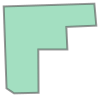

In [14]:
outline_0 = glims_polygons.loc[0, 'geometry']
outline_0

In [15]:
type(outline_0)

shapely.geometry.polygon.Polygon

In [16]:
type(region_1)

geopandas.geodataframe.GeoDataFrame

In [17]:
# Check if outline_0 is within region 1
boolean1 = region_1.contains(outline_0)
boolean1

0    False
dtype: bool

In [18]:
# Check that muir glacier is within region 1. It should be
# Get the 20100915 outline for Muir Glacier
muir_glacier_20100915 = glims_polygons[(
    glims_polygons['src_date'] == "2010-09-15T00:00:00") & (glims_polygons['glac_name'] == "Muir Glacier")]
# check for containment. for some reason this returns false
boolean2 = region_1.contains(muir_glacier_20100915)
boolean2

0       False
5019    False
dtype: bool

In [19]:
# Trying the within function instead fo the contains function. This seemed to work
boolean3 = muir_glacier_20100915.within(region_1.loc[0, 'geometry'])
boolean3

5019    True
dtype: bool

In [20]:
# the polygon at index 116960 keeps causing a topological error for the within function. check out why
outline_116960 = glims_polygons.iloc[116960:116961]
outline_116960

,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,...,rc_id,geog_area,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,geometry
116960,glac_bound,370856.0,G209688E60011N,2010-06-30T00:00:00,0.08,-0.020692,0.0,0.0,0.0,0.0,...,561.0,Various (GlobGlacier),University of Zurich-Irchel,30,30,60,60,"Paul, Frank","Frey, Holger; Le Bris, Raymond; Paul, Frank","POLYGON Z ((-150.315472 60.013026 0, -150.3154..."


In [21]:
# test if I can add buffer to this call
# outline = glims_polygons.loc[index, 'geometry']
outline = glims_polygons.loc[116960, 'geometry'].buffer(0)
outline.is_valid

True

In [22]:
# How do I see the whole geometry? Try writing out to wkt or geojson text files. Also try the make example from week 8 where wrote out to csv file
print(outline_116960['geometry'])

116960    POLYGON Z ((-150.315472 60.013026 0, -150.3154...
Name: geometry, dtype: object


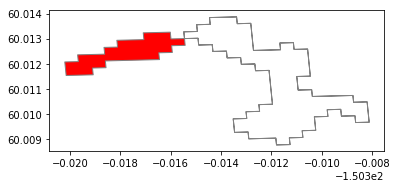

In [23]:
# 
outline_116960.plot(facecolor="red", edgecolor="grey")

In [24]:
outline_116960.bounds

,minx,miny,maxx,maxy
116960,-150.320225,60.008804,-150.308139,60.013887


In [25]:
outline_116960.geometry.type

116960    Polygon
dtype: object

In [26]:
# check if polygon is valid
outline_116960.is_valid

116960    False
dtype: bool

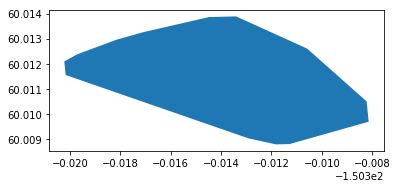

In [27]:
# This is what convex_hull does to the invalid polygon
outline_116960.convex_hull.plot()

In [28]:
# Search for concave hull algorithm in python https://gis.stackexchange.com/questions/268889/creating-concave-hull-with-python
# Jenny suggested try a concave hull algorithm. Geopandas doesn't have one built in so will need to find one and create my own
# function.
#outline_116960.concave_hull.plot()

In [29]:
outline_116960_buffered = outline_116960.buffer(0)
outline_116960_buffered.is_valid

116960    True
dtype: bool

In [30]:
boolean4 = region_1.intersects(muir_glacier_20100915)
boolean4

0       False
5019    False
dtype: bool

In [31]:
type(muir_glacier_20100915)

geopandas.geodataframe.GeoDataFrame

In [32]:
muir_glacier_20100915.crs

{'init': 'epsg:4326'}

In [33]:
region_1.crs

{'init': 'epsg:4326'}

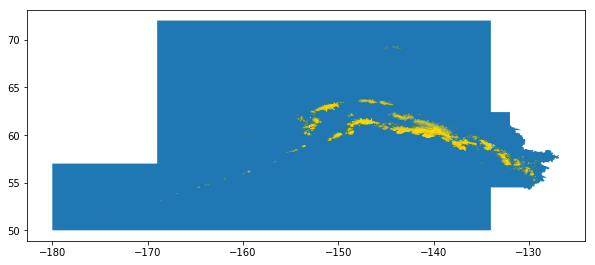

In [34]:
# plot region 1 with muir over the top
fig, ax1 = plt.subplots(figsize=(10, 10))
region_1.plot(ax=ax1)
glims_region_1.plot(ax=ax1, color='gold')

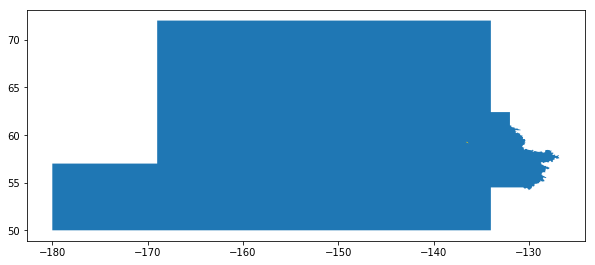

In [35]:
# plot all the glims region 1 outlines in region 1
fig, ax1 = plt.subplots(figsize=(10, 10))
region_1.plot(ax=ax1)
muir_glacier_20100915.plot(ax=ax1, color='gold')

In [36]:
# Conver the lat/lon to a geopandas dataframe
lat_lon_point = np.array([[80, 30]])
geometry = [Point(xy) for xy in lat_lon_point]
point_loc = gpd.GeoDataFrame(geometry,
                             columns=['geometry'],
                             crs={'init': 'epsg:4326'})

In [37]:
type(point_loc)

geopandas.geodataframe.GeoDataFrame

In [38]:
geometry

# Test validiting of glims polygons

In [39]:
# Test how many glims polygons are not valid
# There are 17096 invalid glims polygons
test = "no" # Change to yes if you want to test again
count = 0
if test == "yes":
    for index, row in glims_polygons.iterrows():
        outline = glims_polygons.loc[index, 'geometry']
        boolean = outline.is_valid
        if boolean == False:
            print(index)
            count += 1
    print("Total invalid count:", count)

# Opening test data that has fewer rows than glims to test within function

In [40]:
# open a shapefile using geopandas
plot_centroid_path = "data/test/SJER_plot_centroids.shp"
sjer_plot_locations = gpd.read_file(plot_centroid_path)

# view data attributes
sjer_plot_locations.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,POINT (255852.376 4111567.818)
1,SJER112,center,4111298.971,257406.967,trees,POINT (257406.967 4111298.971)
2,SJER116,center,4110819.876,256838.760,grass,POINT (256838.76 4110819.876)
3,SJER117,center,4108752.026,256176.947,trees,POINT (256176.947 4108752.026)
4,SJER120,center,4110476.079,255968.372,grass,POINT (255968.372 4110476.079)


In [41]:
sjer_plot_locations.shape

(18, 6)

In [42]:
for index, row in sjer_plot_locations.iterrows():
    outline = sjer_plot_locations.loc[index, 'geometry']
    #print(type(outline))
    boolean = outline.within(region_1.loc[0, 'geometry'])
    print(boolean)    

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
